AI Programming - SW Lee

# Lab 04: AlexNet for ImageNet Challenge (ILSVRC)
## Exercise: Image Classification

Load Libraries

In [1]:
import os
# Set the backend of Keras to TensorFlow
os.environ["KERAS_BACKEND"] = "tensorflow"

import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
import keras
import matplotlib.pyplot as plt

# List available GPUs and print the number of GPUs
gpus = tf.config.list_physical_devices('GPU')
print("Num GPUs Available: ", len(gpus))

Num GPUs Available:  1


Prepare Datasets

In [2]:
dataset = 'cifar10'

if dataset == 'cifar10':
    # Load the original CIFAR10 dataset
    # CIFAR10 dataset contains 50000 training images and 10000 test images of 32x32x3 pixels
    # Each image contains a small object such as bird, truck, etc...
    (ds_train, ds_test, ds_val), ds_info = tfds.load('cifar10', split=['train[:80%]', 'test', 'train[80%:]'],
                                                 batch_size=None, shuffle_files=True, as_supervised=True,
                                                 with_info=True)
elif dataset == 'imagenette':
    # Imagenette is a subset of 10 easily classified classes from Imagenet
    # (tench, English springer, cassette player, chain saw, church, French horn, garbage truck, gas pump, golf ball, parachute).
    (ds_train, ds_test, ds_val), ds_info = tfds.load('imagenette/320px-v2', split=['train', 'validation[:50%]', 'validation[50%:]'],
                                                 batch_size=None, shuffle_files=True, as_supervised=True,
                                                 with_info=True)
else:
    print('Dataset Error')

print(ds_info.features)
print(ds_info.splits)
print(ds_info.splits['train'].num_examples)

FeaturesDict({
    'id': Text(shape=(), dtype=string),
    'image': Image(shape=(32, 32, 3), dtype=uint8),
    'label': ClassLabel(shape=(), dtype=int64, num_classes=10),
})
{'train': <SplitInfo num_examples=50000, num_shards=1>, 'test': <SplitInfo num_examples=10000, num_shards=1>}
50000


In [3]:
# Get dataset information
n_channels = ds_info.features['image'].shape[-1]

if dataset == 'imagenette':
    classes = ['tench', 'English springer', 'cassette player', 'chain saw',
               'church', 'French horn', 'garbage truck', 'gas pump',
               'golf ball', 'parachute']
else:
    classes = ds_info.features['label'].names
n_classes = ds_info.features['label'].num_classes

n_train = len(ds_train)
n_test = len(ds_test)
n_val = len(ds_val)

print(n_train,n_test,n_val)

40000 10000 10000


Show a Sample Data

Image demension: (32, 32, 3) , label: 4


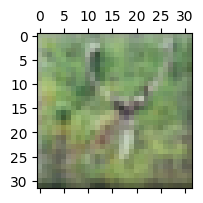

The picture is deer


In [4]:
# Select a random image from the training dataset, visualize the image, and print a class label
idx = np.random.randint(n_train-1)

for element in ds_train.skip(idx).take(1):
    image, label = element

print('Image demension:', image.shape, ', label:',label.numpy())

dimage = tf.reshape(image, image.shape)
plt.figure(figsize=(2,2))
plt.matshow(dimage, 1)
plt.show()
print('The picture is', classes[label])

Building Input Data Pipelines

In [5]:
# Resize the image and normalize it, and convert the label to a one-hot encoded format
def tfds_4_NET(image, label):

    image = tf.image.resize((image / 255), [227,227], method='bilinear')
    label = tf.one_hot(label, n_classes)

    return image, label

In [6]:
# Prepare the training, validation, and test datasets and batching them into batches of size 64
n_batch = 64

dataset = ds_train.map(tfds_4_NET, num_parallel_calls=tf.data.AUTOTUNE)
dataset = dataset.shuffle(buffer_size = 256).batch(batch_size=n_batch)

valiset = ds_val.map(tfds_4_NET, num_parallel_calls=tf.data.AUTOTUNE)
valiset = valiset.shuffle(buffer_size = 256).batch(batch_size=n_batch)

testset = ds_test.map(tfds_4_NET, num_parallel_calls=tf.data.AUTOTUNE)
testset = testset.shuffle(buffer_size = 256).batch(batch_size=n_batch)

### Network Definition of AlexNet with Keras Sequential API



In [7]:
# Define the AlexNet model
AlexNet = keras.Sequential([
    ### START CODE HERE ###

    # Input Layer
    keras.layers.InputLayer(shape=(227,227,3)), # Input layer for 227x227 RGB images

    # Layer 1
    keras.layers.Conv2D(filters=96, kernel_size=(11,11), strides=4, activation='relu'), # Convolution with 96 filters, ReLU activation
    keras.layers.BatchNormalization(),                                                  # Normalize activations
    keras.layers.MaxPool2D(pool_size=(3,3), strides=2),                                 # Downsampling the feature maps

    # Layer 2
    keras.layers.Conv2D(filters=256, kernel_size=(5,5), strides=1, activation='relu', padding='same'),   # Convolution with 256 filters, ReLU activation, same padding
    keras.layers.BatchNormalization(),                                                                   # Normalize activations
    keras.layers.MaxPool2D(pool_size=(3,3), strides=2),                                                  # Downsampling

    # Layer 3 to 5
    keras.layers.Conv2D(filters=384, kernel_size=(3,3), strides=1, activation='relu', padding='same'),  # First convolutional layer
    keras.layers.Conv2D(filters=384, kernel_size=(3,3), strides=1, activation='relu', padding='same'),  # Second convolutional layer
    keras.layers.Conv2D(filters=256, kernel_size=(3,3), strides=1, activation='relu', padding='same'),  # Third convolutional layer
    keras.layers.BatchNormalization(),                                                                  # Normalize activations
    keras.layers.MaxPool2D(pool_size=(3,3), strides=2),                                                 # Downsampling

    keras.layers.Flatten(), # Flatten the output

    # Layer 6 to 8
    keras.layers.Dense(4096, activation='relu'),                                                        # First dense layer
    keras.layers.Dropout(0.5),                                                                          # Dropout for regularization
    keras.layers.Dense(4096, activation='relu'),                                                        # Second dense layer
    keras.layers.Dropout(0.5),                                                                          # Dropout for regularization
    keras.layers.Dense(10, activation='softmax')                                                        # Output layer

    ### END CODE HERE ###
])

AlexNet.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 55, 55, 96)          │          34,944 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 55, 55, 96)          │             384 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 27, 27, 96)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 27, 27, 256)         │         614,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 27, 27, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 13, 13, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 13, 13, 384)         │         885,120 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 13, 13, 384)         │       1,327,488 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 13, 13, 256)         │         884,992 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 13, 13, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 6, 6, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 9216)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 4096)                │      37,752,832 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 4096)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 4096)                │      16,781,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 4096)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 10)                  │          40,970 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 58,324,746 (222.49 MB)

 Trainable params: 58,323,530 (222.49 MB)

 Non-trainable params: 1,216 (4.75 KB)

**Expected Outputs**

```
┏--------------------------------------┳-----------------------------┳-----------------┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡--------------------------------------╇-----------------------------╇-----------------┩
│ conv2d (Conv2D)                      │ (None, 55, 55, 96)          │          34,944 │
├--------------------------------------╇-----------------------------╇-----------------┤
│ batch_normalization                  │ (None, 55, 55, 96)          │             384 │
│ (BatchNormalization)                 │                             │                 │
├--------------------------------------╇-----------------------------╇-----------------┤
│ max_pooling2d (MaxPooling2D)         │ (None, 27, 27, 96)          │               0 │
├--------------------------------------╇-----------------------------╇-----------------┤
│ conv2d_1 (Conv2D)                    │ (None, 27, 27, 256)         │         614,656 │
├--------------------------------------╇-----------------------------╇-----------------┤
│ batch_normalization_1                │ (None, 27, 27, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├--------------------------------------╇-----------------------------╇-----------------┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 13, 13, 256)         │               0 │
├--------------------------------------╇-----------------------------╇-----------------┤
│ conv2d_2 (Conv2D)                    │ (None, 13, 13, 384)         │         885,120 │
├--------------------------------------╇-----------------------------╇-----------------┤
│ conv2d_3 (Conv2D)                    │ (None, 13, 13, 384)         │       1,327,488 │
├--------------------------------------╇-----------------------------╇-----------------┤
│ conv2d_4 (Conv2D)                    │ (None, 13, 13, 256)         │         884,992 │
├--------------------------------------╇-----------------------------╇-----------------┤
│ batch_normalization_2                │ (None, 13, 13, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├--------------------------------------╇-----------------------------╇-----------------┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 6, 6, 256)           │               0 │
├--------------------------------------╇-----------------------------╇-----------------┤
│ flatten (Flatten)                    │ (None, 9216)                │               0 │
├--------------------------------------╇-----------------------------╇-----------------┤
│ dense (Dense)                        │ (None, 4096)                │      37,752,832 │
├--------------------------------------╇-----------------------------╇-----------------┤
│ dropout (Dropout)                    │ (None, 4096)                │               0 │
├--------------------------------------╇-----------------------------╇-----------------┤
│ dense_1 (Dense)                      │ (None, 4096)                │      16,781,312 │
├--------------------------------------╇-----------------------------╇-----------------┤
│ dropout_1 (Dropout)                  │ (None, 4096)                │               0 │
├--------------------------------------╇-----------------------------╇-----------------┤
│ dense_2 (Dense)                      │ (None, 10)                  │          40,970 │
└--------------------------------------┴-----------------------------┴-----------------┘
 Total params: 58,324,746 (222.49 MB)
 Trainable params: 58,323,530 (222.49 MB)
 Non-trainable params: 1,216 (4.75 KB)
 ```

### Training the Model

In [8]:
# Compile AlexNet
opt = keras.optimizers.Adam(learning_rate=0.001)
AlexNet.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['acc'], jit_compile=True)

In [9]:
# Using the training dataset, train the AlexNet model
n_epochs = 10

results = AlexNet.fit(dataset, epochs=n_epochs, batch_size=n_batch,
                   validation_data=valiset, validation_batch_size=n_batch,
                   verbose=1)

Epoch 1/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 103s 134ms/step - acc: 0.2403 - loss: 4.3133 - val_acc: 0.3396 - val_loss: 1.8678
Epoch 2/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 121s 120ms/step - acc: 0.4127 - loss: 1.6336 - val_acc: 0.3972 - val_loss: 1.6250
Epoch 3/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 69s 110ms/step - acc: 0.4802 - loss: 1.4731 - val_acc: 0.4647 - val_loss: 1.5000
Epoch 4/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 81s 109ms/step - acc: 0.5399 - loss: 1.3282 - val_acc: 0.5850 - val_loss: 1.2293
Epoch 5/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 85s 114ms/step - acc: 0.5794 - loss: 1.2130 - val_acc: 0.5463 - val_loss: 1.2686
Epoch 6/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 71s 114ms/step - acc: 0.6220 - loss: 1.1161 - val_acc: 0.5989 - val_loss: 1.1591
Epoch 7/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 77s 106ms/step - acc: 0.6418 - loss: 1.0699 - val_acc: 0.6313 - val_loss: 1.1100
Epoch 8/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 82s 106ms/step - acc: 0.6705 - loss: 0.9674 - val_acc: 0.5627 - val_loss: 1.1838
Epoch 9/10
625/625 ━━━━━━━━━━━

Plot Convergence Graph

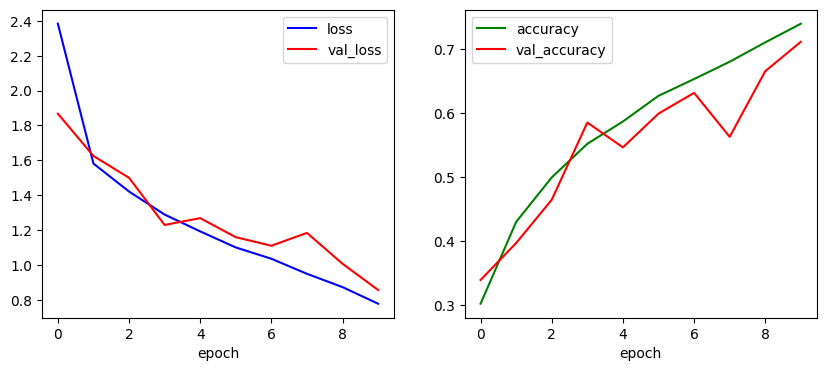

In [10]:
# plot loss and accuracy
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(results.history['loss'], 'b-', label='loss')
plt.plot(results.history['val_loss'], 'r-', label='val_loss')
plt.xlabel('epoch')
plt.legend()

plt.subplot(1,2,2)
plt.plot(results.history['acc'], 'g-', label='accuracy')
plt.plot(results.history['val_acc'], 'r-', label='val_accuracy')
plt.xlabel('epoch')
plt.legend()

plt.show()

Evaluate Model Performance

In [11]:
# Evaluate the performance of the AlexNet model
AlexNet.evaluate(testset)

157/157 ━━━━━━━━━━━━━━━━━━━━ 7s 43ms/step - acc: 0.7093 - loss: 0.8684


[0.8756893277168274, 0.7081000208854675]

### Test Model with a Random Sample


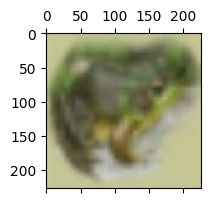

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
My prediction is frog
Actual image is  frog


In [12]:
# Images are randomly selected to compare real class labels with predictions using AlexNet
idx = np.random.randint(n_test-1)

for element in ds_test.skip(idx).take(1):
    img, lbl = element
    X_test, y_test = tfds_4_NET(img, lbl)

X_test = tf.expand_dims(X_test, axis=0)

dimage = np.array(X_test[0])
plt.figure(figsize=(2,2))
plt.matshow(dimage, fignum=1)
plt.show()

outt_4 = AlexNet.predict(X_test)
p_pred = np.argmax(outt_4, axis=-1)

print('My prediction is ' + classes[p_pred[0]])
print('Actual image is  ' + classes[tf.argmax(y_test, -1)])

(c) 2024 SW Lee